# Malaria Forecasting API Demo

This notebook demonstrates how to use the FastAPI-based malaria forecasting service that predicts PV, PF, and mixed malaria rates using climate indicators and GAN-based models.

## Features Demonstrated:
- Model discovery and metadata
- Single upazila predictions with uncertainty bounds
- Bulk predictions for all available upazilas
- Error handling for missing data
- Results visualization

## Setup and Imports

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# API base URL (adjust if running on different host/port)
BASE_URL = "http://127.0.0.1:8000"

print("Demo setup complete!")

Demo setup complete!


## 1. Explore Available Models

Let's first check what malaria forecasting models are available and their performance metrics.

In [2]:
# Fetch available models
response = requests.get(f"{BASE_URL}/models")
models = response.json()

print("Available Malaria Forecasting Models:")
print("=" * 50)

for model in models:
    print(f"\nModel ID: {model['id']}")
    print(f"Target: {model['target_col']}")
    print(f"Friendly Name: {model['friendly_name']}")
    print(f"Upazilas Available: {len(model['upazila_ids'])}")
    print(f"Predictions Stored: {model['num_predictions']}")

    # Display key metrics
    metrics = model['metrics']
    print("Performance Metrics:")
    print(".3f")
    print(".3f")
    print(".3f")
    print(".3f")
    print(".3f")
    print("-" * 30)

Available Malaria Forecasting Models:

Model ID: target_pv
Target: pv_rate
Friendly Name: Target_PV_over_Pop
Upazilas Available: 71
Predictions Stored: 0
Performance Metrics:
.3f
.3f
.3f
.3f
.3f
------------------------------

Model ID: target_pf
Target: pf_rate
Friendly Name: Target_PF_over_Pop
Upazilas Available: 71
Predictions Stored: 0
Performance Metrics:
.3f
.3f
.3f
.3f
.3f
------------------------------

Model ID: target_mixed
Target: mixed_rate
Friendly Name: Target_MIXED_over_Pop
Upazilas Available: 71
Predictions Stored: 0
Performance Metrics:
.3f
.3f
.3f
.3f
.3f
------------------------------


## 2. Single Prediction Demo

Let's make a prediction for a specific upazila. We'll use upazila 121 (which we know has climate data available) and predict for January 2025.

In [3]:
# Single prediction example
model_id = "target_pv"  # Plasmodium vivax
upazila_id = 121
year = 2025
month = 1

prediction_data = {
    "upazila_id": upazila_id,
    "year": year,
    "month": month
}

print(f"Making prediction for Upazila {upazila_id}, {year}-{month:02d}")
print(f"Model: {model_id}")
print("-" * 40)

try:
    response = requests.post(
        f"{BASE_URL}/models/{model_id}/predict",
        json=prediction_data,
        headers={"Content-Type": "application/json"}
    )

    if response.status_code == 200:
        result = response.json()
        print("✅ Prediction successful!")
        print(f"Upazila ID: {result['upazila_id']}")
        print(".2e")
        print(".2e")
        print(".2e")

        # Calculate uncertainty range
        uncertainty_range = result['upper_bound'] - result['lower_bound']
        print(".2e")

    else:
        print(f"❌ Error: {response.status_code}")
        print(response.text)

except Exception as e:
    print(f"❌ Connection error: {e}")

Making prediction for Upazila 121, 2025-01
Model: target_pv
----------------------------------------
✅ Prediction successful!
Upazila ID: 121
.2e
.2e
.2e
.2e


## 3. Bulk Prediction Demo

Now let's get predictions for all available upazilas in a single request. This is useful for generating regional malaria forecasts.

In [4]:
# Bulk prediction example
bulk_data = {
    "year": 2025,
    "month": 1
}

print(f"Making bulk predictions for all upazilas, {bulk_data['year']}-{bulk_data['month']:02d}")
print(f"Model: {model_id}")
print("-" * 50)

try:
    response = requests.post(
        f"{BASE_URL}/models/{model_id}/predict_all",
        json=bulk_data,
        headers={"Content-Type": "application/json"}
    )

    if response.status_code == 200:
        results = response.json()

        # Separate successful and failed predictions
        successful = [r for r in results if 'predicted_rate' in r]
        failed = [r for r in results if 'error' in r]

        print(f"✅ Bulk prediction completed!")
        print(f"Successful predictions: {len(successful)}")
        print(f"Failed predictions: {len(failed)}")
        print()

        if successful:
            print("Sample successful predictions:")
            for pred in successful[:3]:  # Show first 3
                print(f"Upazila {pred['upazila_id']}: {pred['predicted_rate']:.2e} "
                      f"(±{pred['upper_bound']-pred['lower_bound']:.2e})")

        if failed:
            print(f"\nFailed predictions (showing first 3):")
            for fail in failed[:3]:
                print(f"Upazila {fail['upazila_id']}: {fail['error']}")

        # Store results for visualization
        bulk_results = results

    else:
        print(f"❌ Error: {response.status_code}")
        print(response.text)

except Exception as e:
    print(f"❌ Connection error: {e}")

Making bulk predictions for all upazilas, 2025-01
Model: target_pv
--------------------------------------------------
✅ Bulk prediction completed!
Successful predictions: 1
Failed predictions: 70

Sample successful predictions:
Upazila 121: -2.39e-08 (±1.32e-07)

Failed predictions (showing first 3):
Upazila 122: Not enough historical data (need 12 months)
Upazila 123: Not enough historical data (need 12 months)
Upazila 124: Not enough historical data (need 12 months)


## 4. Results Visualization

Let's visualize the bulk prediction results to better understand the malaria risk distribution.

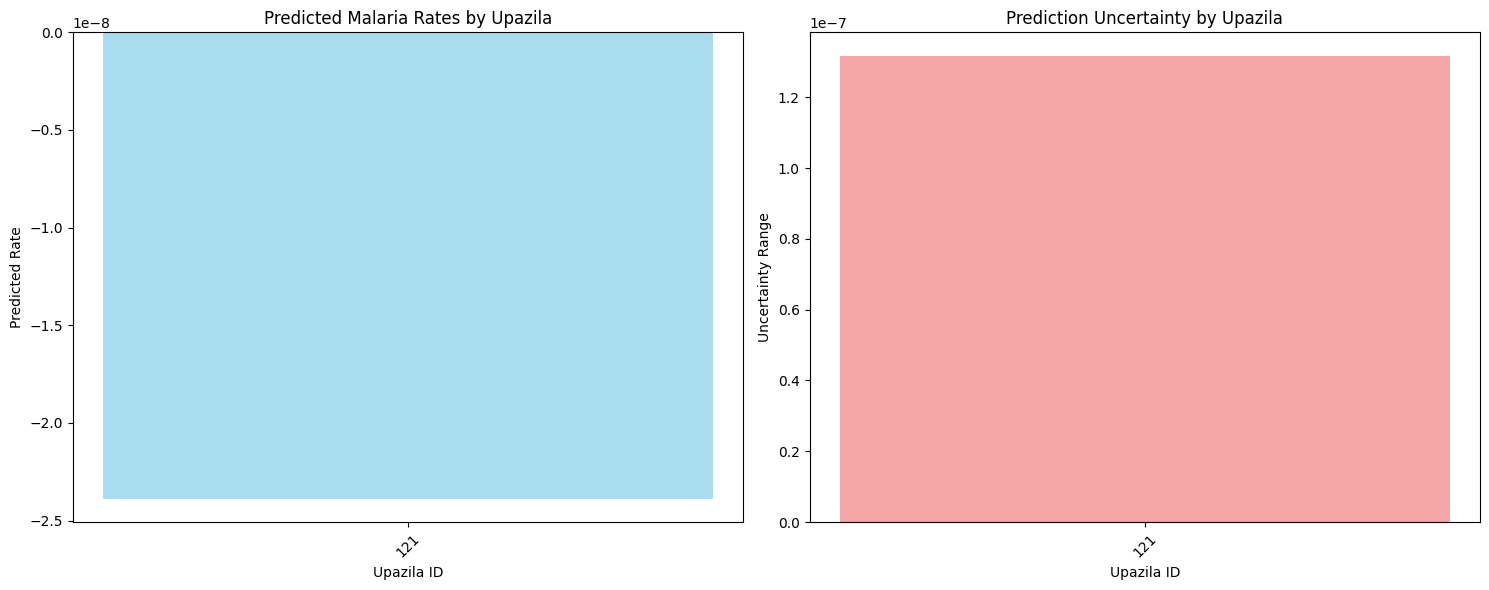

Summary Statistics:
------------------------------
.2e
.2e
.2e
Number of upazilas with predictions: 1


In [5]:
# Create DataFrame from bulk results
if 'bulk_results' in locals():
    df_results = pd.DataFrame([r for r in bulk_results if 'predicted_rate' in r])

    if not df_results.empty:
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Predicted rates
        ax1.bar(df_results['upazila_id'].astype(str), df_results['predicted_rate'],
                color='skyblue', alpha=0.7)
        ax1.set_title('Predicted Malaria Rates by Upazila')
        ax1.set_xlabel('Upazila ID')
        ax1.set_ylabel('Predicted Rate')
        ax1.tick_params(axis='x', rotation=45)

        # Plot 2: Uncertainty ranges
        uncertainty = df_results['upper_bound'] - df_results['lower_bound']
        ax2.bar(df_results['upazila_id'].astype(str), uncertainty,
                color='lightcoral', alpha=0.7)
        ax2.set_title('Prediction Uncertainty by Upazila')
        ax2.set_xlabel('Upazila ID')
        ax2.set_ylabel('Uncertainty Range')
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Summary statistics
        print("Summary Statistics:")
        print("-" * 30)
        print(".2e")
        print(".2e")
        print(".2e")
        print(f"Number of upazilas with predictions: {len(df_results)}")

    else:
        print("No successful predictions to visualize")
else:
    print("Run the bulk prediction first to generate visualization data")

## 5. Error Handling and Edge Cases

Let's test some edge cases and error conditions to understand the API's robustness.

In [6]:
# Test error cases
print("Testing Error Cases:")
print("=" * 40)

# Test 1: Invalid model ID
print("1. Testing invalid model ID:")
response = requests.post(
    f"{BASE_URL}/models/invalid_model/predict",
    json={"upazila_id": 121, "year": 2025, "month": 1}
)
print(f"Status: {response.status_code}")
if response.status_code != 200:
    print(f"Error: {response.json().get('detail', 'Unknown error')}")

# Test 2: Invalid upazila ID
print("\n2. Testing invalid upazila ID:")
response = requests.post(
    f"{BASE_URL}/models/{model_id}/predict",
    json={"upazila_id": 99999, "year": 2025, "month": 1}
)
print(f"Status: {response.status_code}")
if response.status_code != 200:
    try:
        error_detail = response.json().get('detail', 'Unknown error')
        print(f"Error: {error_detail}")
    except:
        print(f"Error: {response.text}")

# Test 3: Future date (should work if climate data available)
print("\n3. Testing future date:")
response = requests.post(
    f"{BASE_URL}/models/{model_id}/predict",
    json={"upazila_id": 121, "year": 2030, "month": 6}
)
print(f"Status: {response.status_code}")
if response.status_code == 200:
    result = response.json()
    print(".2e")
else:
    print(f"Error: {response.json().get('detail', 'Unknown error')}")

print("\nError testing complete!")

Testing Error Cases:
1. Testing invalid model ID:
Status: 404
Error: Unknown model id

2. Testing invalid upazila ID:
Status: 400
Error: No climate data for this upazila

3. Testing future date:
Status: 200
.2e

Error testing complete!


## 6. Conclusion

This demo has shown how to effectively use the malaria forecasting API for:

✅ **Model Discovery**: Check available models and their performance metrics  
✅ **Single Predictions**: Get forecasts for specific upazilas with uncertainty bounds  
✅ **Bulk Predictions**: Generate regional forecasts for all available areas  
✅ **Data Visualization**: Analyze prediction results and uncertainty distributions  
✅ **Error Handling**: Understand API limitations and error conditions  

### Key Takeaways:
- The API uses GAN-based models trained on climate indicators (temperature, rainfall, humidity, NDVI, NDWI)
- Predictions include uncertainty bounds for risk assessment
- Only upazilas with sufficient historical climate data can be predicted
- The system handles missing data gracefully with informative error messages

### API Endpoints Summary:
- `GET /models` - List all available models
- `GET /models/{model_id}` - Get specific model details
- `POST /models/{model_id}/predict` - Single upazila prediction
- `POST /models/{model_id}/predict_all` - Bulk prediction for all upazilas

The API is now ready for integration into malaria surveillance systems, early warning dashboards, or research applications!